The minimum number of cancellations recorded in a week was 14, while the maximum number of cancellations recorded in a week was 222.  
Make an assumption about the mean and standard deviation of the distribution.  
You are assuming that weekly hotel cancellations follow a normal distribution.  

 - Use PyMC3 to generate a predictive posterior distribution, such as a distribution that reflects an updated estimate of the mean and standard deviation given the data in question. (Hint: Make sure your standard deviation is sizable enough to account for the fact that your prior mean estimate may have been significantly different from the true estimate.)
 - Report the mean and standard deviation as generated by the posterior distribution.

Make an assumption about mean and standard deviation parameters based on the information you have been given about the minimum and maximum cancellations recorded in a given week.
 - Build a model with PyMC3 (pm.Model) that models a normal distribution. Generate 1,000 samples using this model.
 - Obtain the mean and standard deviation of the (updated) posterior distribution.
 - Plot the posterior predictive mean observations against the actual observations.
 - Report whether the peak of the true mean coincides with the peak of the posterior predictive mean.
 
 - A model built in PyMC3 that generates a posterior distribution. Calculate the mean and standard deviation of this new distribution and plot this distribution against the true mean. Report whether the peak of the true mean coincides with the peak of the posterior predictive mean.
 
`Posterior Distribution = Prior Distribution * Likelihood Function`

In [8]:
import os

import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Assumptions
min_cancel = 14
max_cancel = 222
mean_cancel = 118

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

### 1. Import Libraries and Load Data

In [26]:
df = pd.read_csv(os.path.join('data', 'h1weekly.csv'))
df.shape

(115, 2)

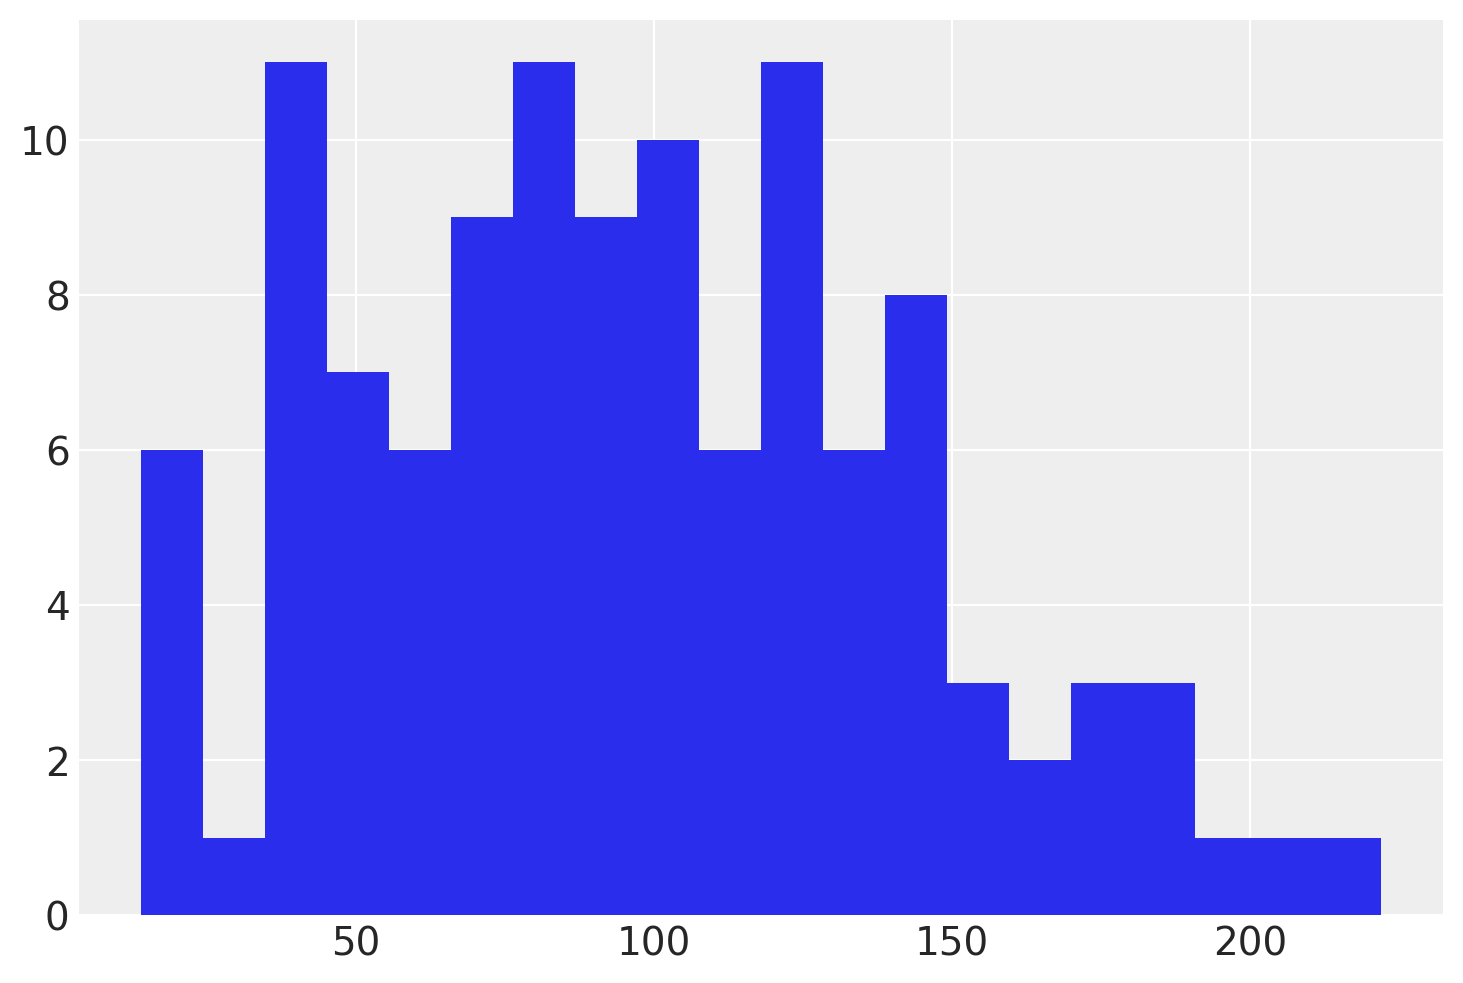

In [27]:
df['IsCanceled'].hist(bins=20);

In [28]:
df['IsCanceled'].describe()

count    115.000000
mean      96.713043
std       45.865510
min       14.000000
25%       64.000000
50%       95.000000
75%      127.500000
max      222.000000
Name: IsCanceled, dtype: float64

In [29]:
data = df['IsCanceled'].values

### 2. Define priors and generate 1000 samples

In [31]:
# Priors
mu_prior = 118  # mean
sigma_prior = 10 # stdev

In [32]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=mu_prior, sigma=sigma_prior)
    sd = pm.HalfNormal("sd", sigma=sigma_prior) # Half of normal, also uses sigma prior
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)
    idata = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
The acceptance probability does not match the target. It is 0.8801688159412218, but should be close to 0.8. Try to increase the number of tuning steps.


In [33]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)
# add posterior predictive to the InferenceData
az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

c:\users\garyb\venv\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


### 3. Generate posterior plots

HDI - Highest Density Interval (related to Highest-Posterior Density (HPD) interval)

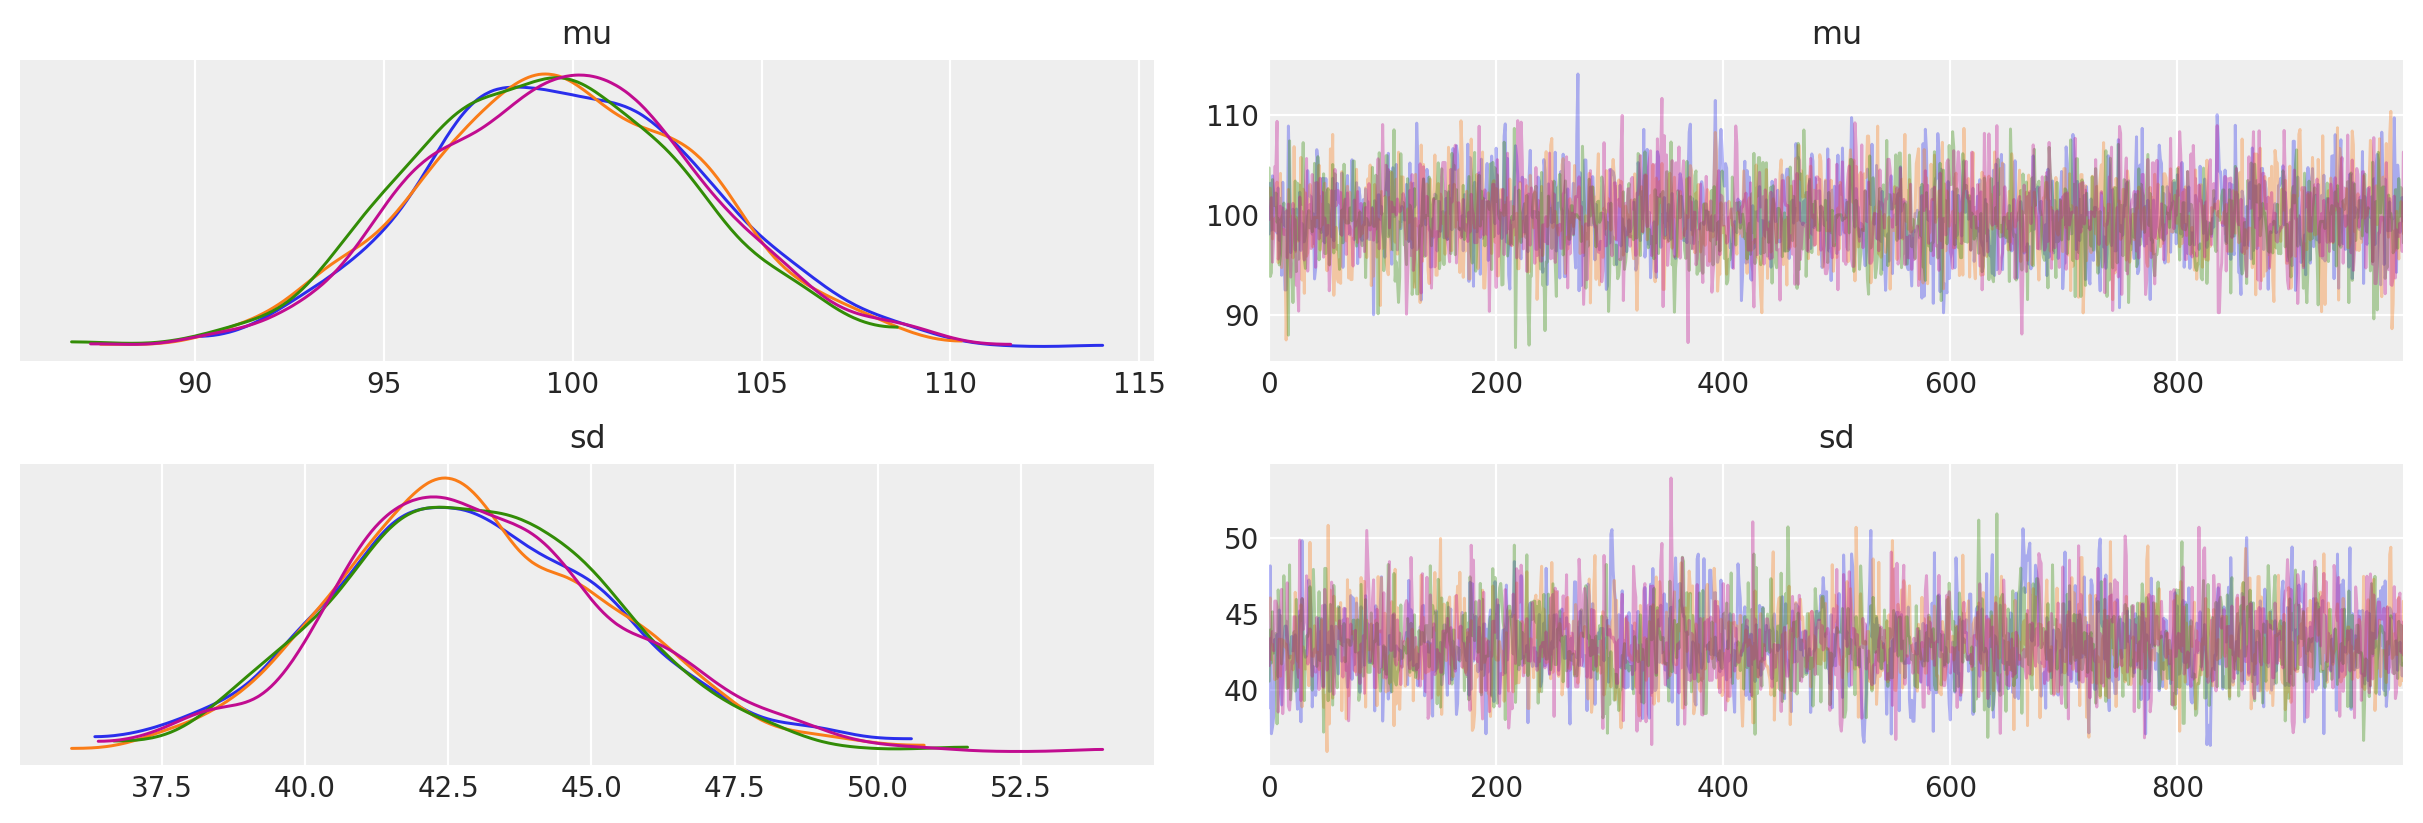

In [34]:
az.plot_trace(idata);

Left is Kernel Density Estimation (KDE) - basically a histogram  
Right is individual samples

In [35]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,99.665,3.700,92.868,106.582,0.064,0.045,3373.0,3373.0,3368.0,2987.0,1.0
sd,43.000,2.446,38.355,47.536,0.043,0.030,3257.0,3229.0,3284.0,2731.0,1.0


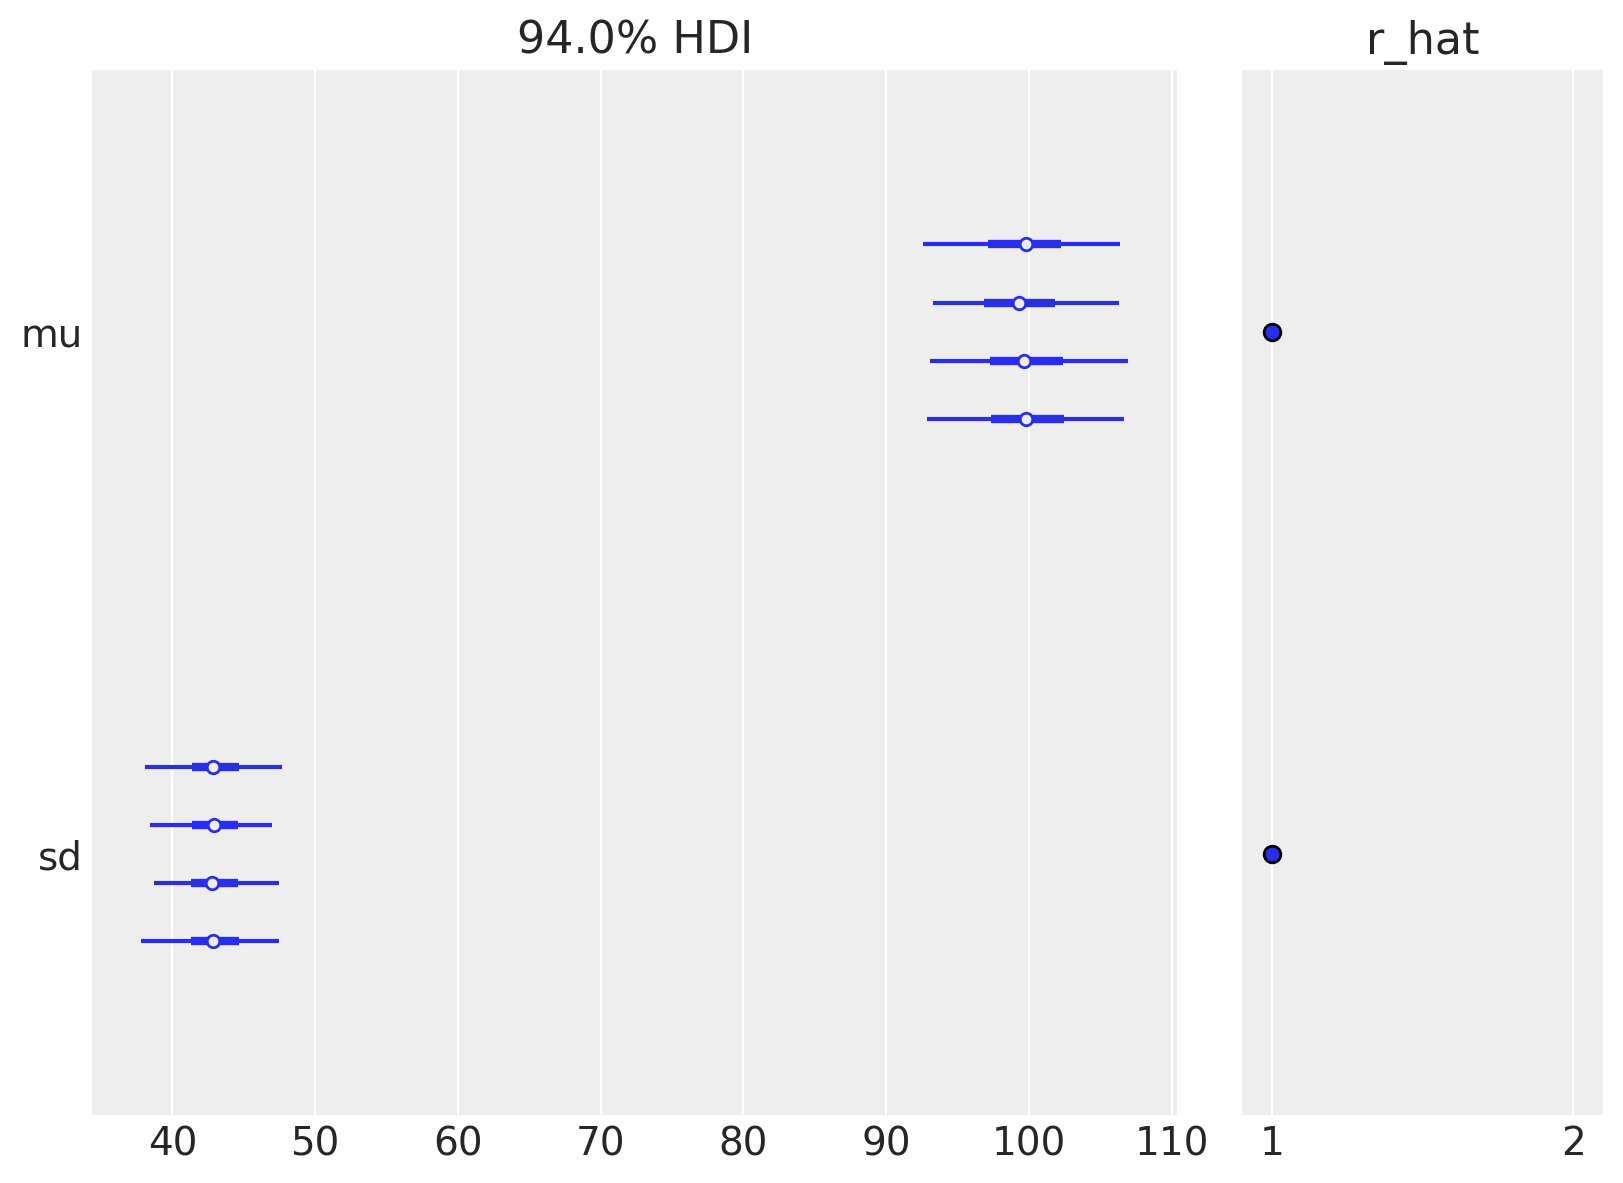

In [36]:
az.plot_forest(idata, r_hat=True);

TODO: Understand this chart

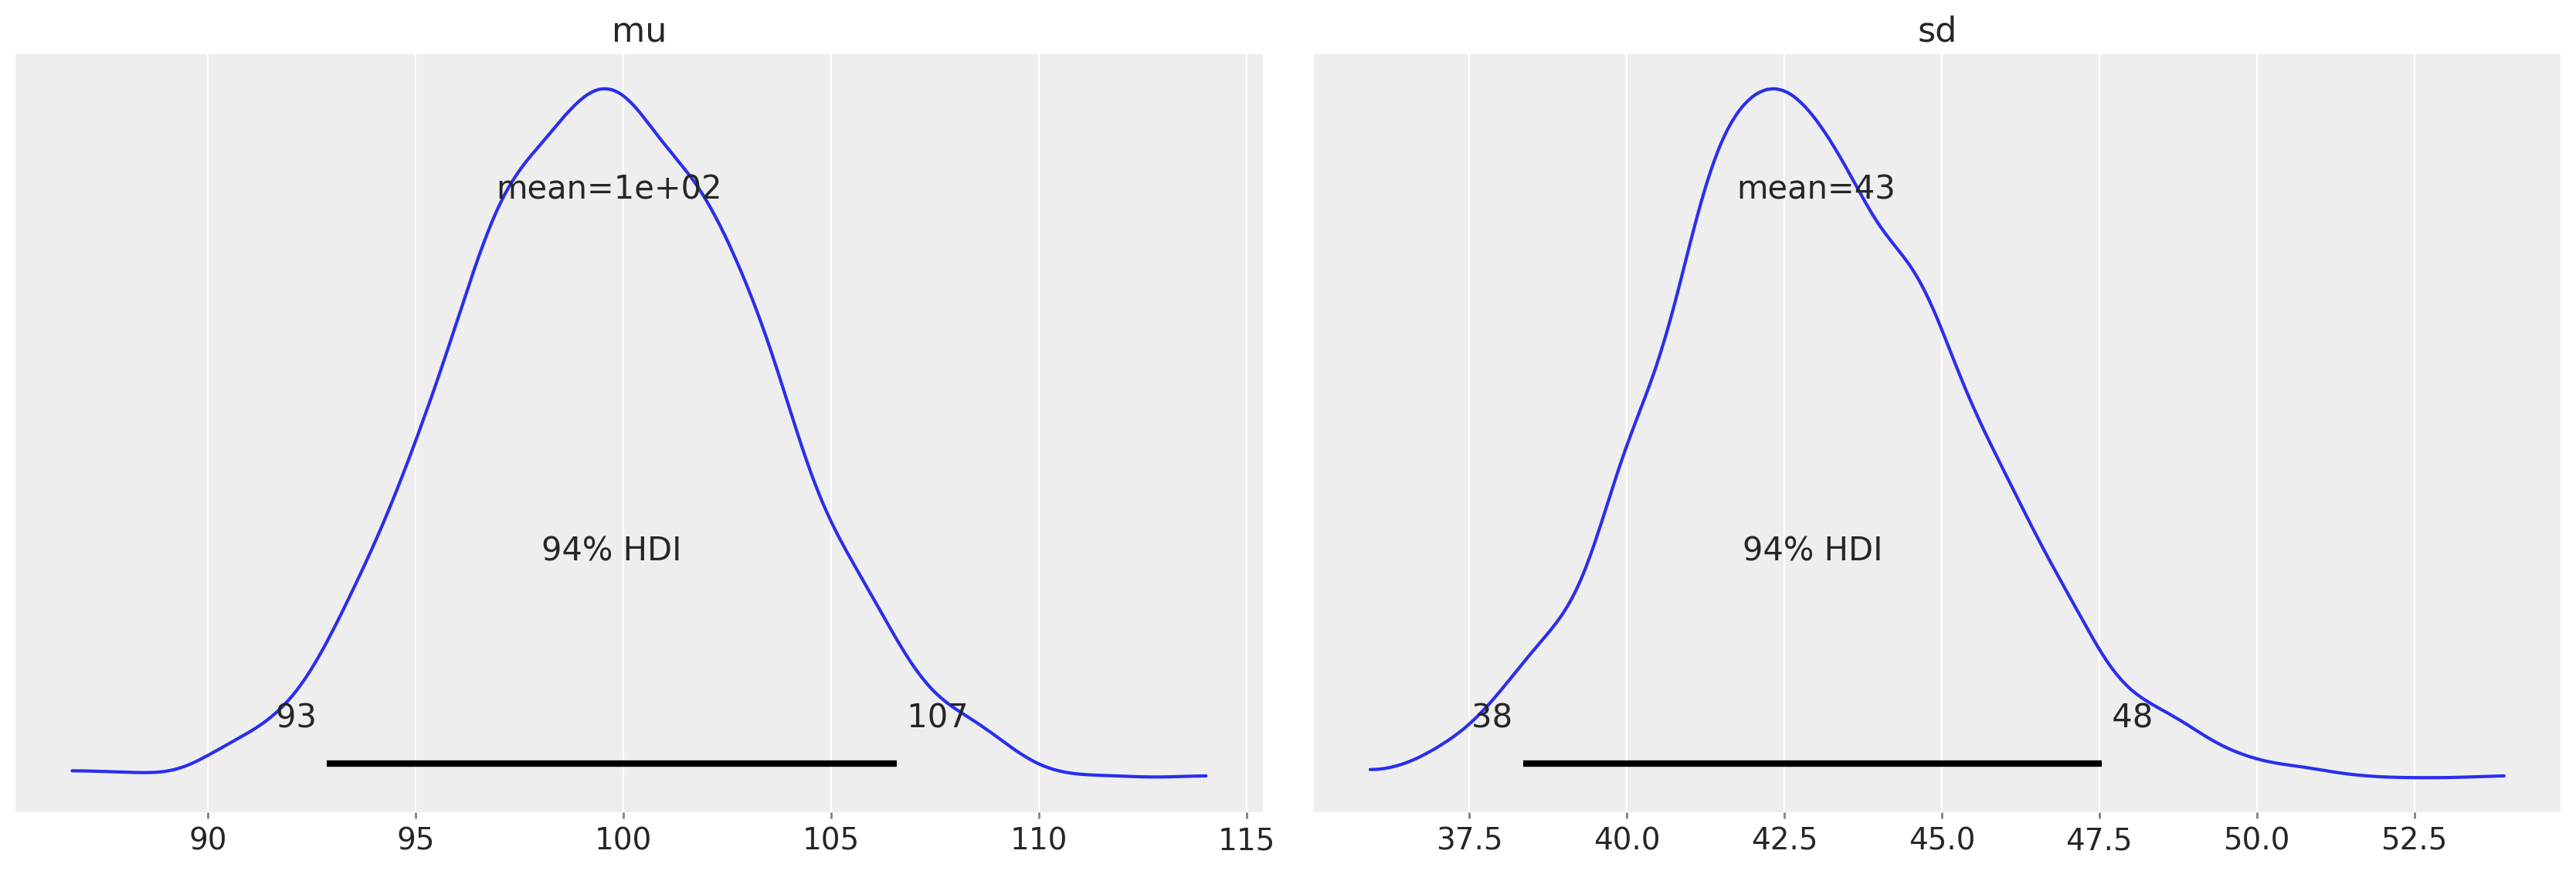

In [37]:
az.plot_posterior(idata);

Shows KDE values and HDI_94%

Plot observed vs posterior predictions

c:\users\garyb\venv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


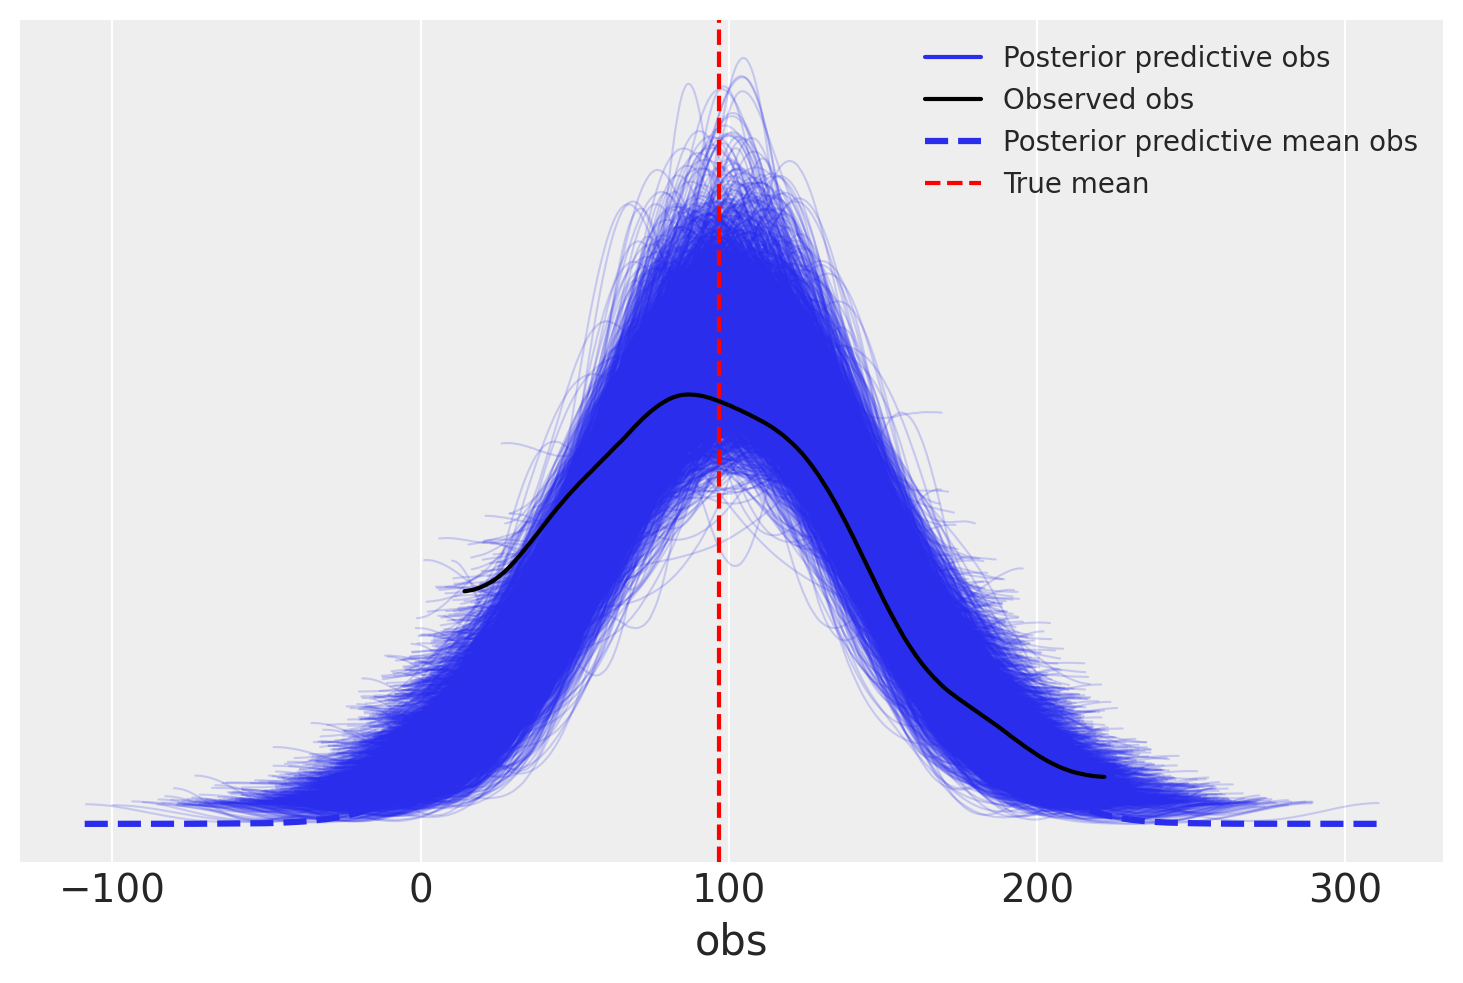

In [38]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);